# Dana's FitBit Reporting Example for total Miles/Day and Sleep

* https://github.com/tuchandra/sleep-analysis/blob/master/stats-and-sleep.ipynb

### REMEMBER: Fitbit API is metered per user, you can do up to 150 requests per user per hour


In [13]:
import fitbit
import keyring
import gather_keys_oauth2 as Oauth2
import pandas as pd 
import datetime
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

DATE_FORMAT = '%Y-%m-%d'

In [14]:
# keyring set system CLIENT_ID
# password for 'CLIENT_ID': (paste_password_here)

# retrieve username & password
CLIENT_ID = keyring.get_password("fitbit", "username")
CLIENT_SECRET = keyring.get_password("fitbit", "password")

server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET) # For easy use insert CLIENT_ID, CLIENT_SECRET
server.browser_authorize()

ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])
auth2_client = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

[07/May/2020:10:56:53] ENGINE Listening for SIGTERM.
[07/May/2020:10:56:53] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[07/May/2020:10:56:53] ENGINE Set handler for console events.
[07/May/2020:10:56:53] ENGINE Started monitor thread 'Autoreloader'.
[07/May/2020:10:56:53] ENGINE Serving on http://127.0.0.1:8080
[07/May/2020:10:56:54] ENGINE Bus STARTED


127.0.0.1 - - [07/May/2020:10:56:55] "GET /?code=2dd5d2ac2b3602772a640407722c4a0a6769aa8b&state=32e0stO0U7gHUwilMqJeFtG2vhdEcD HTTP/1.1" 200 122 "" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.129 Safari/537.36"


[07/May/2020:10:56:56] ENGINE Bus STOPPING
[07/May/2020:10:56:56] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[07/May/2020:10:56:56] ENGINE Stopped thread 'Autoreloader'.
[07/May/2020:10:56:56] ENGINE Removed handler for console events.
[07/May/2020:10:56:56] ENGINE Bus STOPPED
[07/May/2020:10:56:56] ENGINE Bus EXITING
[07/May/2020:10:56:56] ENGINE Waiting for child threads to terminate...
[07/May/2020:10:56:56] ENGINE Bus EXITED
[07/May/2020:10:56:56] ENGINE Waiting for thread Thread-33.


In [135]:
# https://github.com/yashatgit/fitbit-analyzer/blob/master/Fitbit_Data_Collection.ipynb

def safeGet(obj, key, defaultVal = np.nan):
    return obj.get(key, defaultVal) 

def filterArrObj(arrList, keyName, keyValue):
    for arrItem in arrList:
        if arrItem.get(keyName) == keyValue:
            return arrItem
    return {} 


def getActivitiesData(date):
    activitiyResponse = auth2_client.activities(date=date)
    
    activitySummary = activitiyResponse['summary'];
    activityData = {
        
        'DateTime': date
        , 'Calories_Burned':safeGet(activitySummary,'caloriesOut')
        , 'Calories_BMR': safeGet(activitySummary,'caloriesBMR')
        , 'Resting_Heart_Rate':safeGet(activitySummary,'restingHeartRate')
        , 'Steps':safeGet(activitySummary,'steps')
        , 'Distance_Run_miles':filterArrObj(activitySummary.get('distances', []), 'activity', 'Run').get('distance', np.nan)
        , 'Distance_veryActive_miles':filterArrObj(activitySummary.get('distances', []), 'activity', 'veryActive').get('distance', np.nan)
        , 'Distance_moderatelyActive_miles':filterArrObj(activitySummary.get('distances', []), 'activity', 'moderatelyActive').get('distance', np.nan)
        , 'Distance_lightlyActive_miles':filterArrObj(activitySummary.get('distances', []), 'activity', 'lightlyActive').get('distance', np.nan)
        , 'Dist_Tot_miles':filterArrObj(activitySummary.get('distances', []), 'activity', 'total').get('distance', np.nan)
        , 'Elevation_ft':activitySummary['elevation']
        , 'Floors':activitySummary['floors']
        , 'Min_Sedentary':activitySummary['sedentaryMinutes']
        , 'Min_Lightly_Active':activitySummary['lightlyActiveMinutes']
        , 'Min_Fairly_Active':activitySummary['fairlyActiveMinutes']
        , 'Min_Very_Active':activitySummary['veryActiveMinutes']
        , 'Activity_Calories': activitySummary['activityCalories']
        , 'Active_Score': activitySummary['activeScore']
        , 'Cardio_min': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Cardio').get('minutes', np.nan)
        , 'Cardio_calories': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Cardio').get('caloriesOut', np.nan)
        , 'Fat_Burn_min': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Fat Burn').get('minutes', np.nan)
        , 'Fat_Burn_calories': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Fat Burn').get('caloriesOut', np.nan)
        , 'Peak_min': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Peak').get('minutes', np.nan)
        , 'Peak_calories': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Peak').get('caloriesOut', np.nan)
        , 'Normal_Cardio_min': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Out of Range').get('minutes', np.nan)
        , 'Normal_Cardio_calories': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Out of Range').get('caloriesOut', np.nan)
    }
    
    return activityData


def getSleepData(date):
    
    try:
        summarydata = auth2_client.sleep(date=date)['sleep'][0]
        
        summary_data_dict = {'Date': summarydata['dateOfSleep']
            , 'MainSleep':summarydata['isMainSleep']
            , 'Efficiency':summarydata['efficiency']
            , 'Duration':summarydata['duration']
            , 'Minutes Asleep':summarydata['minutesAsleep']
            , 'Minutes Awake':summarydata['minutesAwake']
            , 'Awakenings':summarydata['awakeCount']
            , 'Restless Count':summarydata['restlessCount']
            , 'Restless Duration':summarydata['restlessDuration']
            , 'Time in Bed_min':summarydata['timeInBed']
            , 'Time in Bed_hours':summarydata['timeInBed']/60
                    }
        return summary_data_dict
    except: 
        pass

# Get Activities Data

In [6]:
days = 90

endDate = pd.datetime.today().date()
startDate = str(
        datetime.datetime.strftime((datetime.datetime.now() - datetime.timedelta(days=days)), "%Y-%m-%d"))
allDates = pd.date_range(start=startDate, end=endDate)
print(len(allDates))

#data_list = [getActivitiesData(date) for date in allDates]


91


In [7]:
df = pd.DataFrame(data_list)
df.head()

,DateTime,Calories_Burned,Calories_BMR,Resting_Heart_Rate,Steps,Distance_Run_miles,Distance_veryActive_miles,Distance_moderatelyActive_miles,Distance_lightlyActive_miles,Dist_Tot_miles,...,Activity_Calories,Active_Score,Cardio_min,Cardio_calories,Fat_Burn_min,Fat_Burn_calories,Peak_min,Peak_calories,Normal_Cardio_min,Normal_Cardio_calories
0,2020-02-07,2142,1528,64.0,3525,NaN,0.06,0.07,1.32,1.47,...,734,-1,0,0.00000,106,418.84065,0,0.0,1332,1721.22804
1,2020-02-08,2397,1528,64.0,8921,NaN,1.80,0.47,1.55,3.84,...,1040,-1,6,54.99606,127,649.97274,0,0.0,1274,1656.78285
2,2020-02-09,1981,1528,65.0,3288,NaN,0.11,0.06,1.24,1.41,...,582,-1,1,8.28126,48,208.51788,0,0.0,1381,1754.03457
3,2020-02-10,3114,1528,64.0,18817,NaN,2.44,1.52,4.01,7.99,...,1983,-1,11,100.01214,239,1172.54148,0,0.0,881,1512.07314
4,2020-02-11,2431,1528,65.0,10640,NaN,1.77,0.37,2.35,4.49,...,1049,-1,8,80.15835,120,571.08843,0,0.0,1304,1771.76496


In [10]:
df_date = df.set_index("DateTime")


### Define Weekends/Weekday

In [246]:
# Add column and labels for day of week
df_date["day_of_week"] = df_date.index.weekday
days = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 
        5: "Saturday", 6: "Sunday"}
df_date["day_name"] = df_date["day_of_week"].apply(lambda x: days[x])

weekends = ["Saturday", "Sunday"]
df_date_weekends = df_date[df_date['day_name'].isin(weekends)]
df_date = df_date[~df_date['day_name'].isin(weekends)]

### Weekday Reporting

Text(0, 0.5, 'Dist_Tot_miles')

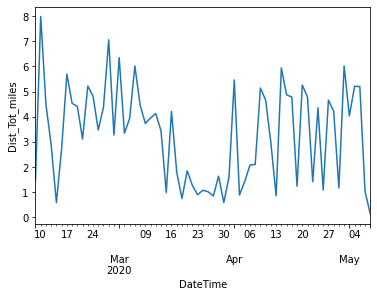

In [243]:
df_date["Dist_Tot_miles"].plot()
plt.ylabel("Dist_Tot_miles")

Text(0, 0.5, 'Dist_Tot_miles')

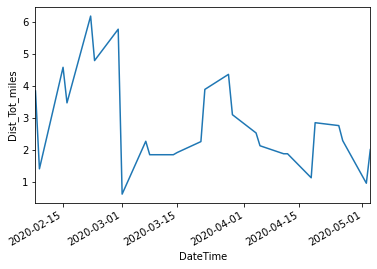

In [244]:
df_date_weekends["Dist_Tot_miles"].plot()
plt.ylabel("Dist_Tot_miles")

In [247]:
# Create a fitted model for duration vs. date
df_date['date_delta'] = np.arange(len(df_date))

In [248]:
model = smf.ols(formula = 'Dist_Tot_miles ~ date_delta', data = df_date).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.8313,0.471,8.137,0.000,2.890,4.772
date_delta,-0.0165,0.013,-1.298,0.199,-0.042,0.009


Qualitatively, we can see from the line graph above that the plot is very noisy, and it's hard to see that any trend exists. 

* confidence interval for the linear coefficient is (-0.029, 0.000), which includes zero
* p-value is 0.044. 

We d not conclude there is a significant trend in my total miles a day over the course of the quarentine.

We can also graph the regression line against the actual data (as a scatterplot, this time, for readability) to see this.

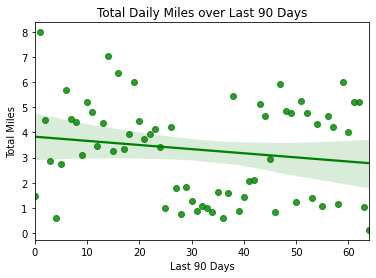

In [255]:
# Plot the durations with the regression line
sns.regplot(x = df_date.date_delta, y = df_date.Dist_Tot_miles, color = "g")
plt.xlabel("Last 90 Days")
plt.ylabel("Total Miles")
plt.title("Total Daily Miles over Last 90 Days");


In [250]:
# Add column and labels for day of week
df_date["day_of_week"] = df_date.index.weekday
days = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 
        5: "Saturday", 6: "Sunday"}
df_date["day_name"] = df_date["day_of_week"].apply(lambda x: days[x])


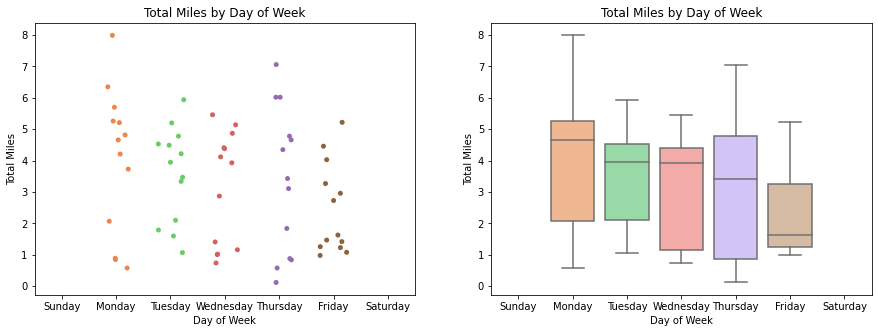

In [251]:

# Create plots
days_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 5))
sns.stripplot(x = df_date.day_name, y = df_date.Dist_Tot_miles, jitter = 0.25, order = days_order, palette = "muted", ax = ax1)
sns.boxplot(x = df_date.day_name, y = df_date.Dist_Tot_miles, order = days_order, palette = "pastel", ax = ax2)

# Label axes
ax1.set_xlabel("Day of Week")
ax1.set_ylabel("Total Miles")
ax1.set_title("Total Miles by Day of Week") 
ax2.set_xlabel("Day of Week")
ax2.set_ylabel("Total Miles")
ax2.set_title("Total Miles by Day of Week") ;

# Get Sleep Data

* Duration is initiall a value in milliseconds (divide by 60000 to get min)
* https://dev.fitbit.com/build/reference/web-api/sleep/

In [252]:
# data_sleep = [getSleepData(date) for date in allDates]

In [253]:
print(len(data_sleep))

91


In [144]:
data_sleep2=  [x for x in data_sleep if isinstance(x, dict)]


In [236]:
df2 = pd.DataFrame(data_sleep2)
df2['Date'] =  pd.to_datetime(df2['Date'], format=DATE_FORMAT)

# Create a fitted model for duration vs. date
df2['date_delta'] = np.arange(len(df2))
df2["Duration"] /= 60

df2.head(20)

,Date,MainSleep,Efficiency,Duration,Minutes Asleep,Minutes Awake,Awakenings,Restless Count,Restless Duration,Time in Bed_min,Time in Bed_hours,date_delta
0,2020-02-07,True,97,523000.0,505,18,1,9,16,523,8.716667,0
1,2020-02-08,True,98,533000.0,520,13,0,7,13,533,8.883333,1
2,2020-02-09,True,98,563000.0,553,10,1,6,9,563,9.383333,2
3,2020-02-10,True,93,129000.0,118,9,1,4,9,129,2.150000,3
4,2020-02-11,False,97,78000.0,76,2,0,2,2,78,1.300000,4
5,2020-02-12,True,94,369000.0,348,21,1,8,20,369,6.150000,5
6,2020-02-13,True,97,493000.0,477,16,1,10,15,493,8.216667,6
7,2020-02-14,True,98,482000.0,472,10,0,4,10,482,8.033333,7
8,2020-02-15,True,97,447000.0,432,15,2,4,9,447,7.450000,8
9,2020-02-16,True,98,449000.0,441,8,1,6,6,449,7.483333,9


### Average Efficiency

In [203]:
df2.Efficiency.mean()

95.51190476190476

In [290]:
dfs = df2.set_index("Date")
dfs['Duration'] /= 60000
print(len(dfs))
dfs =  dfs[dfs['Minutes Asleep'] > 120]
print(len(dfs))

84
72


### Define Weekends/Weekday

In [291]:
# Add column and labels for day of week
dfs["day_of_week"] = dfs.index.weekday
days = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 
        5: "Saturday", 6: "Sunday"}
dfs["day_name"] = dfs["day_of_week"].apply(lambda x: days[x])

weekends = ["Saturday", "Sunday"]
dfs_weekends = dfs[dfs['day_name'].isin(weekends)]
dfs = dfs[~dfs['day_name'].isin(weekends)]

Text(0, 0.5, 'Duration')

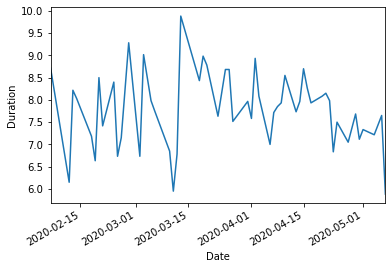

In [292]:
dfs["Duration"].plot()
plt.ylabel("Duration")

Text(0, 0.5, 'Duration')

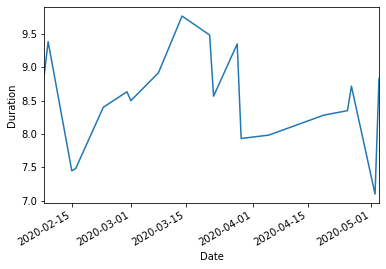

In [293]:
dfs_weekends["Duration"].plot()
plt.ylabel("Duration")

In [294]:
# Create a fitted model for duration vs. date
model = smf.ols(formula = 'Duration ~ date_delta', data = dfs).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.9321,0.242,32.839,0.000,7.447,8.417
date_delta,-0.0034,0.005,-0.680,0.499,-0.013,0.007


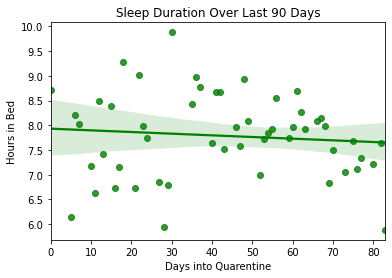

In [295]:
# Plot the durations with the regression line
sns.regplot(x = dfs.date_delta, y = dfs.Duration, color = "g")
plt.xlabel("Days into Quarentine")
plt.ylabel("Hours in Bed")
plt.title("Sleep Duration Over Last 90 Days");


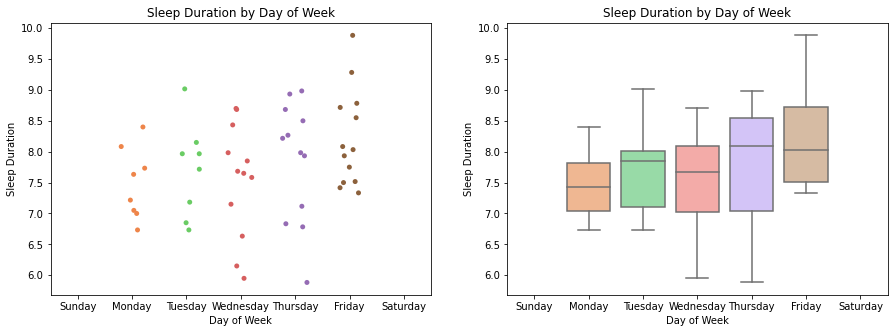

In [296]:
dataframe = dfs

# Create plots
days_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 5))
sns.stripplot(x = dataframe.day_name, y = dataframe.Duration, jitter = 0.25, order = days_order, palette = "muted", ax = ax1)
sns.boxplot(x = dataframe.day_name, y = dataframe.Duration, order = days_order, palette = "pastel", ax = ax2)

# Label axes
ax1.set_xlabel("Day of Week")
ax1.set_ylabel("Sleep Duration")
ax1.set_title("Sleep Duration by Day of Week") 
ax2.set_xlabel("Day of Week")
ax2.set_ylabel("Sleep Duration")
ax2.set_title("Sleep Duration by Day of Week") ;

## The (Sleep) Debt Crisis

Next, I want to study the question of sleep debt. The idea that one can "catch up on sleep" has often been debated by scientists. But anecdotal experience from my college career fully supports the idea that if I don't sleep much one night, I will likely be sleeping more the next night.

Let's look into this. I once again consider all my data, and include naps this time (since if I'm taking a nap to catch up on sleep, it make sense to include that). We take the duration of sleep from each night and subtract from it the duration of sleep the night before. This gives a "duration difference" that tells us how much more we slept that night than the previous.

In [271]:
dfs_diff = pd.DataFrame(dfs, columns = ["Duration"])
dfs_diff.head()

,Duration
Date,
2020-02-07,8.716667
2020-02-12,6.150000
2020-02-13,8.216667
2020-02-14,8.033333
2020-02-18,7.183333


In [272]:
# Set duration_prev to duration of sleep the day before
dfs_diff["duration_prev"] = dfs_diff.shift(1).Duration

# Set duration_diff to difference between current night and previous night of sleep
dfs_diff["duration_diff"] = dfs_diff.Duration - dfs_diff.duration_prev

dfs_diff.head()

,Duration,duration_prev,duration_diff
Date,,,
2020-02-07,8.716667,NaN,NaN
2020-02-12,6.150000,8.716667,-2.566667
2020-02-13,8.216667,6.150000,2.066667
2020-02-14,8.033333,8.216667,-0.183333
2020-02-18,7.183333,8.033333,-0.850000


Next, we can perform regression analysis on this. Let's plot the difference in sleep durations versus how much I slept the night before, and construct a linear model as before.

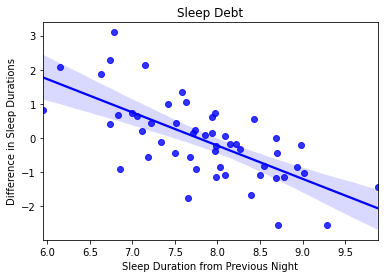

In [273]:
# Plot how much more I slept each night vs. amount slept night before
sns.regplot(x = dfs_diff.duration_prev, y = dfs_diff.duration_diff, color = "b")
plt.xlabel("Sleep Duration from Previous Night")
plt.ylabel("Difference in Sleep Durations")
plt.title("Sleep Debt");


We visually see a strong negative association between these two factors, and our regression analysis tells us that the relationship is significant. Indeed, it seems that on nights when I slept fewer than 7.6 hours, I was likely to sleep more the next night. Conversely, on nights where I slept more than that, I was likely to sleep less the next night.

In [274]:
model = smf.ols(formula = 'duration_diff ~ duration_prev', data = dfs_diff).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.5808,1.158,6.548,0.000,5.255,9.906
duration_prev,-0.9758,0.147,-6.629,0.000,-1.271,-0.680


In [210]:
model.rsquared

0.3923550426483524